In [427]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import scipy
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## Dataset

In [5]:
wine = datasets.load_wine()
x = wine.data[:,[1,2]]

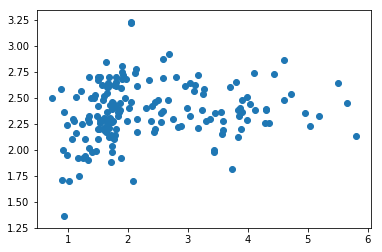

In [6]:
plt.scatter(x[:,0], x[:,1])
plt.show()

In [38]:
def make_ellipse(cen, cov, ax):
    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(cen, v[0], v[1], 180 + angle)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)
    ax.set_aspect('equal', 'datalim')

In [67]:
def plot_2d_clusters(centers, covariances, x, clusters):
    ax = plt.subplot(1, 1, 1)
    for k in range(len(centers)):
        plt.scatter(x[:,0][clusters == k], x[:,1][clusters == k])
        make_ellipses(centers[k], covariances[k], ax)
    plt.scatter(centers[:,0], centers[:,1], marker='x', s=100)
    plt.show()

## Sklearn EM

In [68]:
K = 3
em = GaussianMixture(K)
cl = em.fit_predict(x)

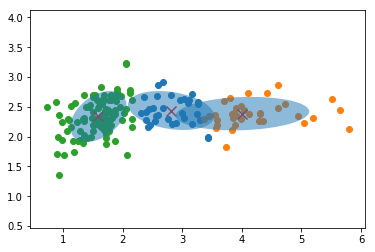

In [69]:
plot_2d_clusters(em.means_, em.covariances_, x, cl)

In [70]:
em.weights_

array([0.17209227, 0.22014455, 0.60776317])

In [74]:
em.bic(x)

550.8272234428115

In [75]:
em.score(x)

-1.2998227614827138

In [79]:
D = []
for k in range(1, 21):
    em = GaussianMixture(K)
    em.fit(x)
    D.append([k, em.bic(x), em.aic(x)])
D = np.array(D)

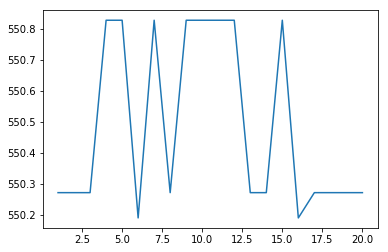

In [81]:
plt.plot(D[:,0], D[:,1])
plt.show()

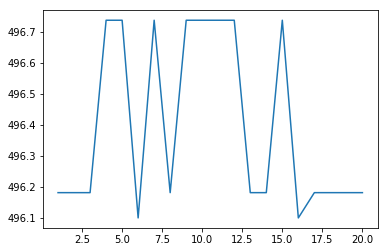

In [82]:
plt.plot(D[:,0], D[:,2])
plt.show()

## Gaussian mixture

In [84]:
def normpdf(x, mean, sd):
    var = float(sd) ** 2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [106]:
X_ = np.arange(0, 20, 0.1)
Y1 = np.array([normpdf(x, 5, 1) for x in X_])
Y2 = np.array([normpdf(x, 12, 2) for x in X_])
Y_ = Y1 + Y2

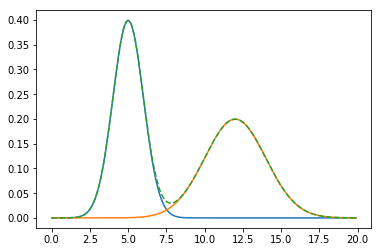

In [112]:
plt.plot(X_, Y1)
plt.plot(X_, Y2)
plt.plot(X_, Y_, '--')
plt.show()

In [380]:
def plot_mix1d(K, X, M, S, Xd, P = None):
    colors = ['b','g','r','c','m','y','b']
    plt.scatter(X, np.zeros_like(X))
    for k in range(K):
        plt.plot(Xd, np.array([normpdf(x, M[k], S[k]) for x in Xd]), color = colors[k])
        if P is not None:
            plt.bar(X + k*0.2, P[:,k], width=0.2, color = colors[k])
    plt.show()

## EM in steps

### Initialize

In [497]:
X_ = np.array([1, 2, 3, 4, 7, 7.5, 8, 8.5, 9, 9.5, 10])
Xd = np.arange(0, 11, 0.1)
K = 2

In [498]:
M_ = KMeans(K).fit(X_[:,np.newaxis]).cluster_centers_.reshape((K))
S_ = np.array([1., 1.])
P_ = np.array([0.5, 0.5])

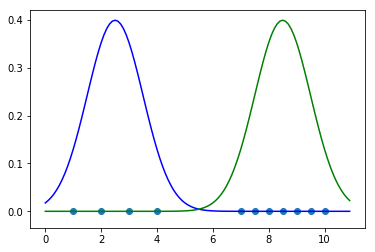

M = [2.5 8.5]
S = [1. 1.]


In [499]:
plot_mix1d(K, X_, M_, S_, Xd)
print(f'M = {M_}')
print(f'S = {S_}')

### Iteration #1

In [500]:
Px = np.zeros((len(X_),K))
for k in range(K):
    Px[:,k] = np.array([normpdf(x, M_[k], S_[k]) for x in X_])
Px

array([[1.29517596e-01, 2.43432053e-13],
       [3.52065327e-01, 2.66955661e-10],
       [3.52065327e-01, 1.07697600e-07],
       [1.29517596e-01, 1.59837411e-05],
       [1.59837411e-05, 1.29517596e-01],
       [1.48671951e-06, 2.41970725e-01],
       [1.07697600e-07, 3.52065327e-01],
       [6.07588285e-09, 3.98942280e-01],
       [2.66955661e-10, 3.52065327e-01],
       [9.13472041e-12, 2.41970725e-01],
       [2.43432053e-13, 1.29517596e-01]])

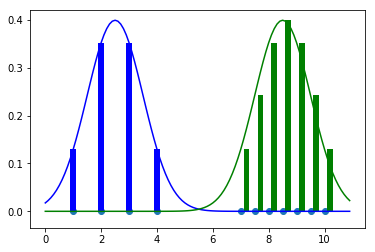

M = [2.5 8.5]
S = [1. 1.]


In [501]:
plot_mix1d(K, X_, M_, S_, Xd, Px)
print(f'M = {M_}')
print(f'S = {S_}')

In [502]:
a = np.multiply(Px, P_)
b = np.sum(a, axis=1)
Pk = np.divide(a, np.append(b[:,np.newaxis],b[:,np.newaxis],axis=1))
Pk

array([[1.00000000e+00, 1.87952882e-12],
       [9.99999999e-01, 7.58256042e-10],
       [9.99999694e-01, 3.05902227e-07],
       [9.99876605e-01, 1.23394576e-04],
       [1.23394576e-04, 9.99876605e-01],
       [6.14417460e-06, 9.99993856e-01],
       [3.05902227e-07, 9.99999694e-01],
       [1.52299795e-08, 9.99999985e-01],
       [7.58256042e-10, 9.99999999e-01],
       [3.77513454e-11, 1.00000000e+00],
       [1.87952882e-12, 1.00000000e+00]])

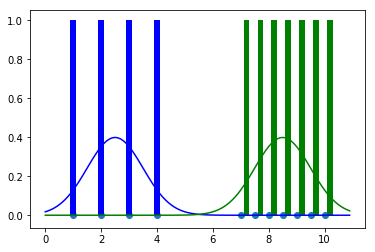

In [503]:
plot_mix1d(K, X_, M_, S_, Xd, Pk)

In [504]:
for k in range(K):
    M_[k] = np.sum(np.multiply(Pk[:,k], X_)) / np.sum(Pk[:,k])
M_

array([2.50010063, 8.49994778])

In [505]:
for k in range(K):
    S_[k] = np.sum(np.multiply(Pk[:,k], np.power(X_ - M_[k], 2))) / np.sum(Pk[:,k])
S_

array([1.25059418, 1.00031862])

In [506]:
P_ = np.sum(Pk, axis = 0) / len(X_)
P_

array([0.36363692, 0.63636308])

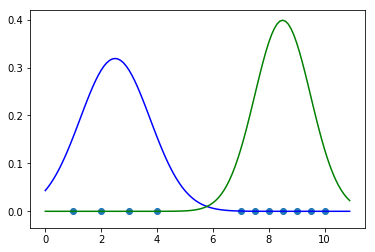

M = [2.50010063 8.49994778]
S = [1.25059418 1.00031862]


In [507]:
plot_mix1d(K, X_, M_, S_, Xd)
print(f'M = {M_}')
print(f'S = {S_}')

### Iteration #2

In [508]:
Px = np.zeros((len(X_),K))
for k in range(K):
    Px[:,k] = np.array([normpdf(x, M_[k], S_[k]) for x in X_])

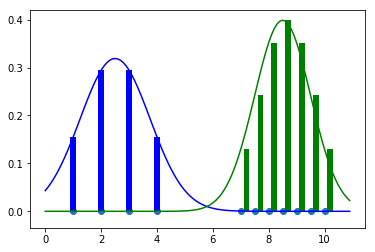

In [509]:
plot_mix1d(K, X_, M_, S_, Xd, Px)

In [510]:
a = np.multiply(Px, P_)
b = np.sum(a, axis=1)
Pk = np.divide(a, np.append(b[:,np.newaxis],b[:,np.newaxis],axis=1))
Pk

array([[1.00000000e+00, 2.79170415e-12],
       [9.99999998e-01, 1.60790151e-09],
       [9.99999354e-01, 6.46123834e-07],
       [9.99818882e-01, 1.81117544e-04],
       [2.16695547e-03, 9.97833045e-01],
       [2.54650863e-04, 9.99745349e-01],
       [3.26880174e-05, 9.99967312e-01],
       [4.59019531e-06, 9.99995410e-01],
       [7.05255687e-07, 9.99999295e-01],
       [1.18561575e-07, 9.99999881e-01],
       [2.18084336e-08, 9.99999978e-01]])

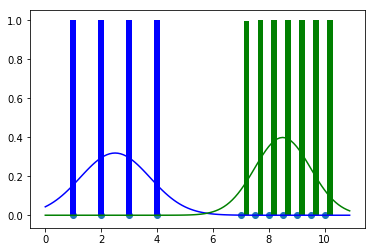

In [511]:
plot_mix1d(K, X_, M_, S_, Xd, Pk)

In [512]:
for k in range(K):
    M_[k] = np.sum(np.multiply(Pk[:,k], X_)) / np.sum(Pk[:,k])
M_

array([2.5027398 , 8.50038617])

In [513]:
for k in range(K):
    S_[k] = np.sum(np.multiply(Pk[:,k], np.power(X_ - M_[k], 2))) / np.sum(Pk[:,k])
S_

array([1.26203136, 1.00011795])

In [514]:
P_ = np.sum(Pk, axis = 0) / len(X_)
P_

array([0.36384345, 0.63615655])

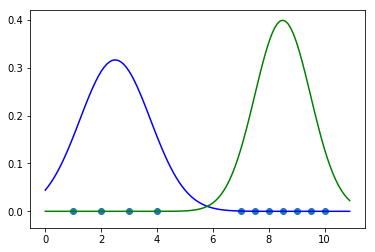

M = [2.5027398  8.50038617]
S = [1.26203136 1.00011795]


In [515]:
plot_mix1d(K, X_, M_, S_, Xd)
print(f'M = {M_}')
print(f'S = {S_}')

## EM algorithm

In [516]:
def E_step(K, X, M, S):
    P1 = np.zeros((len(X),K))
    for k in range(K):
        P1[:,k] = np.array([normpdf(x, M[k], S[k]) for x in X])
    return P1

In [520]:
def M_step(K, X, P0, P1):
    
    a = np.multiply(P0, P1)
    b = np.sum(a, axis=1)
    P = np.divide(a, np.append(b[:,np.newaxis], b[:,np.newaxis],axis=1))
    
    M = np.zeros((K))
    S = np.zeros((K))
    
    for k in range(K):
        M[k] = np.sum(np.multiply(P[:,k], X)) / np.sum(P[:,k])
        S[k] = np.sum(np.multiply(P[:,k], np.power(X - M[k], 2))) / np.sum(P[:,k])
    
    P0 = np.sum(P, axis = 0) / len(P)
    
    return M, S, P0

In [525]:
def EM1d(K, X):
    
    M  = KMeans(K).fit(X[:,np.newaxis]).cluster_centers_.reshape((K))
    S  = np.ones((K)).astype(float)
    P0 = np.zeros((K)).astype(float)
    P0[:] = 1/K
    
    while True:
        
        M_prev = np.copy(M)
        S_prev = np.copy(S)
        
        P1 = E_step(K, X, M, S)
        
#         plot_mix1d(K, X, M, S, Xd, P1)
#         print(f'M = {M}')
#         print(f'S = {S}')

        M, S, P0 = M_step(K, X, P0, P1)
        
        if np.all(M_prev == M) and np.all(S_prev == S): break
            
    return M, S, P1

In [527]:
M, S, P = EM1d(2, X_)

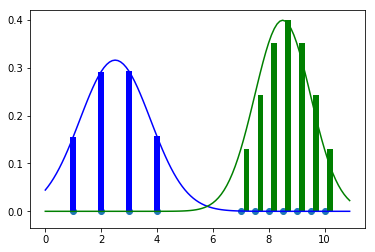

M = [2.50316337 8.50046233]
S = [1.26385866 1.0000551 ]


In [529]:
plot_mix1d(K, X_, M, S, Xd, P)
print(f'M = {M}')
print(f'S = {S}')

### Sklearn EM

In [459]:
em = GaussianMixture(K)
cl = em.fit_predict(X_[:,np.newaxis])

In [531]:
print(f'M = {np.squeeze(em.means_).tolist()}')
print(f'S = {np.squeeze(em.covariances_).tolist()}')

M = [8.499985144465755, 2.500527631694066]
S = [1.000448793636682, 1.2525180365104556]
